# 프로젝트 : 주식 예측 도전!

### Step 1. 시계열 데이터 준비

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from matplotlib import font_manager, rc

font_fname = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_name = font_manager.FontProperties(fname=font_fname).get_name()

rc('font', family=font_name)

Duplicate key in file PosixPath('/home/aiffel-dj12/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/mpl-data/matplotlibrc'), line 250 ('font.family:  sans-serif')


In [2]:
dataset_filepath = os.getenv('HOME')+'/aiffel/stock_prediction/data/005930.KS.csv' 
df = pd.read_csv(dataset_filepath) 
print(type(df))

<class 'pandas.core.frame.DataFrame'>


In [3]:
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
print(type(df))
df.head()

<class 'pandas.core.frame.DataFrame'>


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-04,6000.0,6110.0,5660.0,6110.0,4761.183105,74195000.0
2000-01-05,5800.0,6060.0,5520.0,5580.0,4348.184082,74680000.0
2000-01-06,5750.0,5780.0,5580.0,5620.0,4379.354004,54390000.0
2000-01-07,5560.0,5670.0,5360.0,5540.0,4317.015625,40305000.0
2000-01-10,5600.0,5770.0,5580.0,5770.0,4496.240723,46880000.0


In [4]:
ts1 = df['Close'] #Close 로 시계열 데이터 변환 
print(type(ts1))
ts1.head()

<class 'pandas.core.series.Series'>


Date
2000-01-04    6110.0
2000-01-05    5580.0
2000-01-06    5620.0
2000-01-07    5540.0
2000-01-10    5770.0
Name: Close, dtype: float64

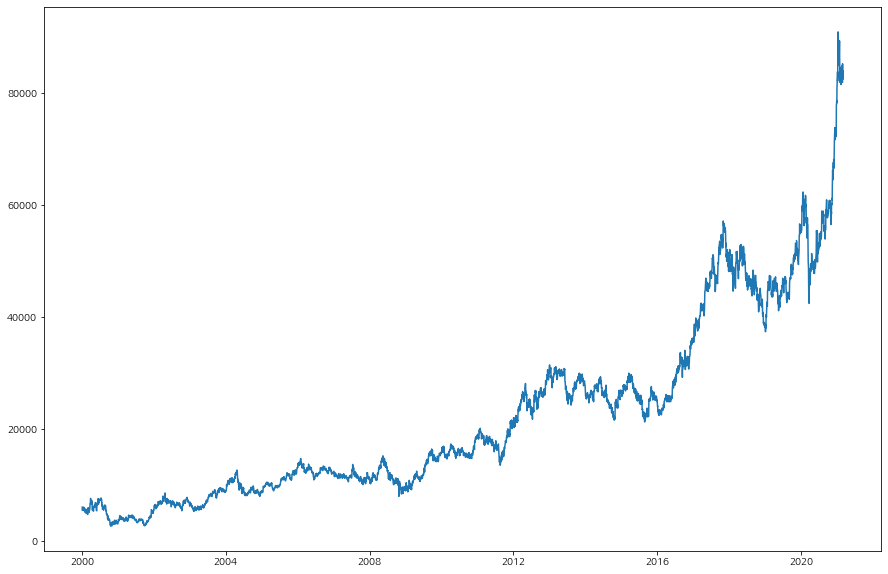

In [5]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15,10# 차트 크기

# 시계열(time series) 데이터를 차트로 그려 봅시다.
plt.plot(ts1)

### Step 2. 각종 전처리 

#### 결측치 처리 

In [6]:
ts1[ts1.isna()]  # 시계열(Time Series)에서 결측치가 있는 부분만 Series로 출력합니다.

Date
2005-01-03   NaN
2017-11-16   NaN
2017-11-23   NaN
2018-01-02   NaN
2018-11-15   NaN
2019-11-14   NaN
Name: Close, dtype: float64

In [7]:
ts1=ts1.interpolate(method='time')
ts1[ts1.isna()]

Series([], Name: Close, dtype: float64)

In [8]:
# #dropna 이용하여 삭제를 해버림 
# ts1=ts1.dropna()

# # 삭제 이후 결측치(NaN) 유무를 다시 확인합니다.
# ts1[ts1.isna()]

# # 다시 그래프를 확인해봅시다!
# plt.plot(ts1)

#### 로그 변환

In [9]:
ts_log = np.log(ts1)
#plt.plot(ts_log)

In [10]:
#augmented_dickey_fuller_test(ts_log)

### Step 3. 시계열 안정성 분석

#### -정성적 그래프 분석

In [11]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

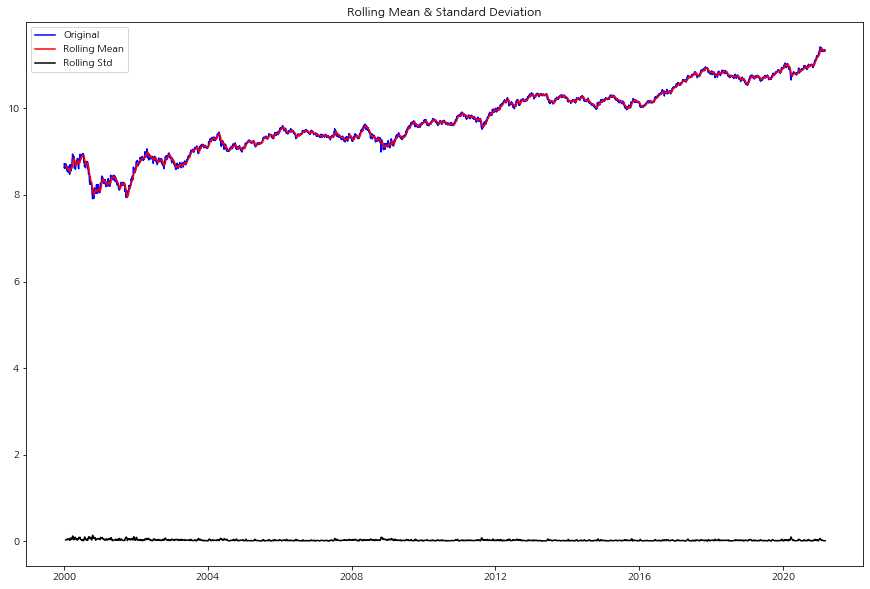

In [12]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#### -정량적 Augmented Dicky-Fuller Test

In [13]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [14]:
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                   -0.300283
p-value                           0.925464
#Lags Used                        4.000000
Number of Observations Used    5315.000000
Critical Value (1%)              -3.431581
Critical Value (5%)              -2.862084
Critical Value (10%)             -2.567060
dtype: float64


#### -시계열 분해(Time Series Decomposition)

/home/aiffel-dj12/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/aiffel-dj12/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


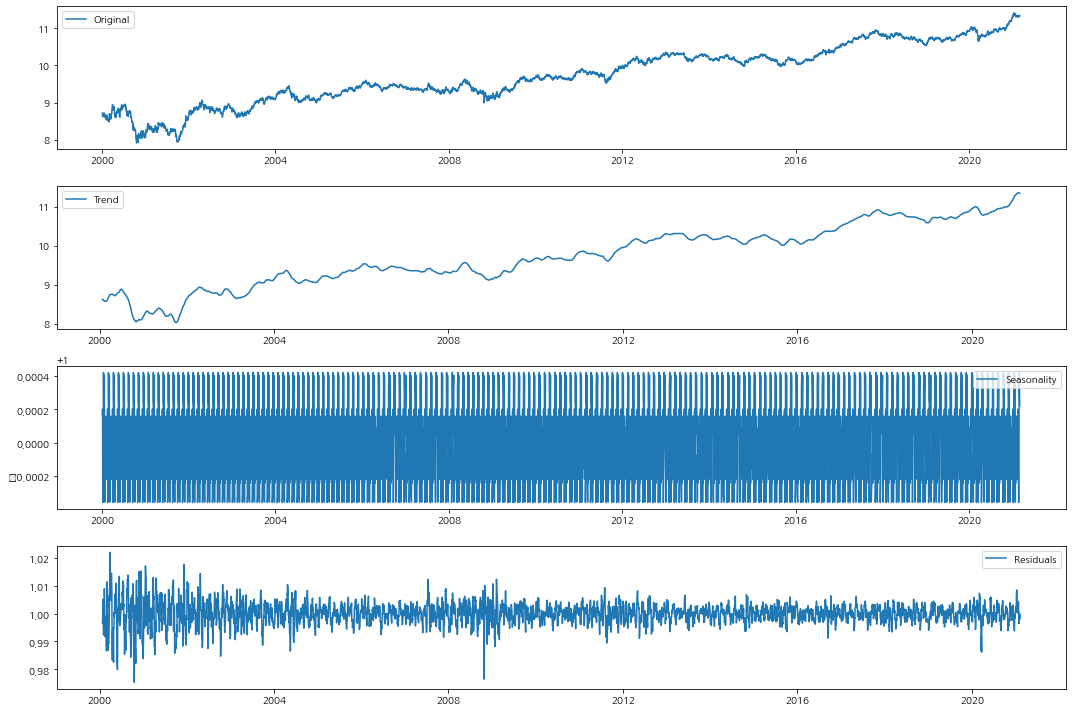

In [15]:
#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

#### -Residual 안정성 확인

In [16]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -1.760269e+01
p-value                        3.914322e-30
#Lags Used                     3.300000e+01
Number of Observations Used    5.256000e+03
Critical Value (1%)           -3.431595e+00
Critical Value (5%)           -2.862090e+00
Critical Value (10%)          -2.567063e+00
dtype: float64


In [17]:
##### augmented_dickey_fuller_test(ts1)

### Step 4. 학습, 테스트 데이터셋 생성

#### 학습, 테스트 데이터셋 분리

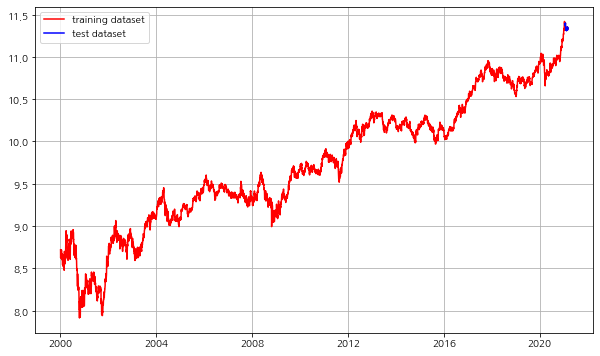

In [18]:
train_data, test_data = ts_log[:int(len(ts_log)*0.995)], ts_log[int(len(ts_log)*0.995):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

### Step 5. 적정 ARIMA모수 찾기

#### ACF, PACF 그려보기 -> p,q 구하기
#### 차분 안정성 확인 -> d 구하기

/home/aiffel-dj12/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/aiffel-dj12/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


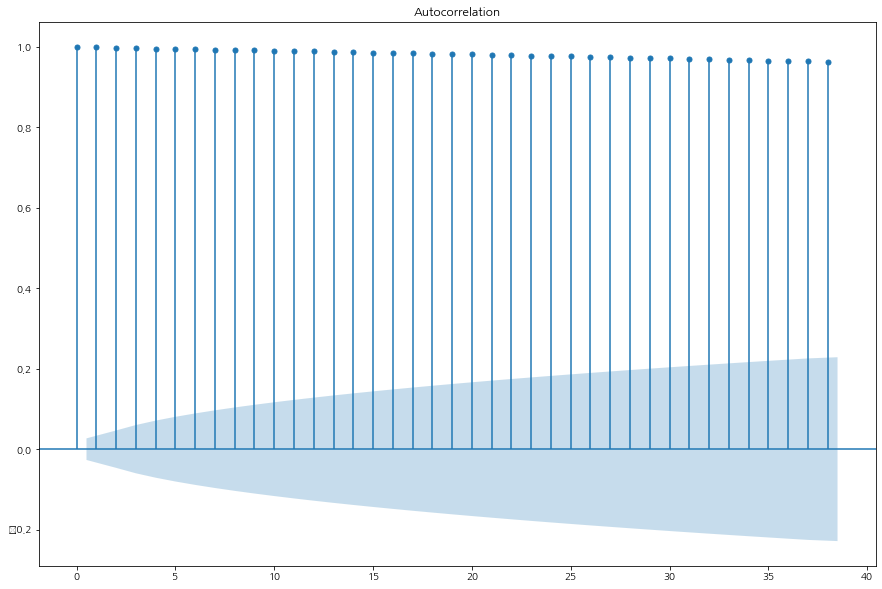

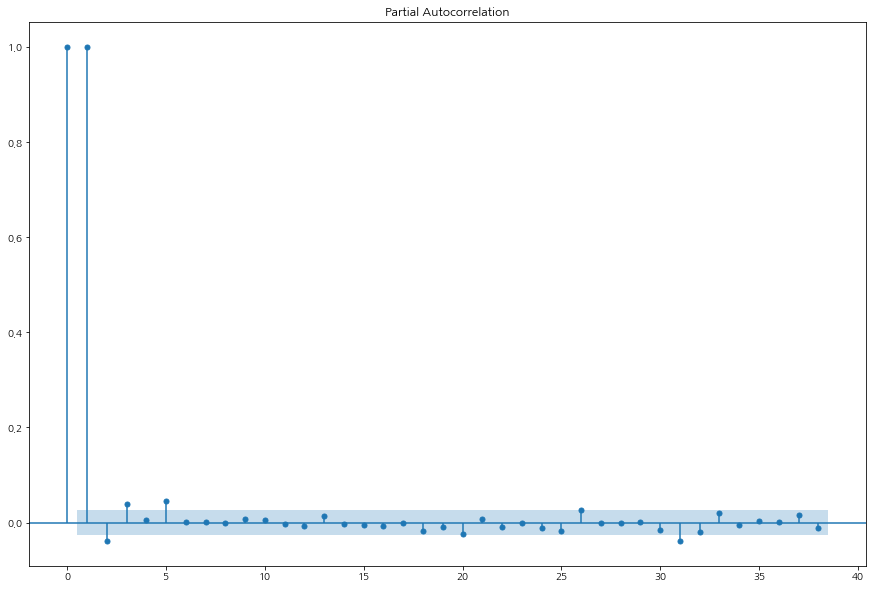

In [19]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                  -40.107780
p-value                           0.000000
#Lags Used                        3.000000
Number of Observations Used    5315.000000
Critical Value (1%)              -3.431581
Critical Value (5%)              -2.862084
Critical Value (10%)             -2.567060
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                  -21.841431
p-value                           0.000000
#Lags Used                       33.000000
Number of Observations Used    5284.000000
Critical Value (1%)              -3.431588
Critical Value (5%)              -2.862087
Critical Value (10%)             -2.567061
dtype: float64


/home/aiffel-dj12/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/aiffel-dj12/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


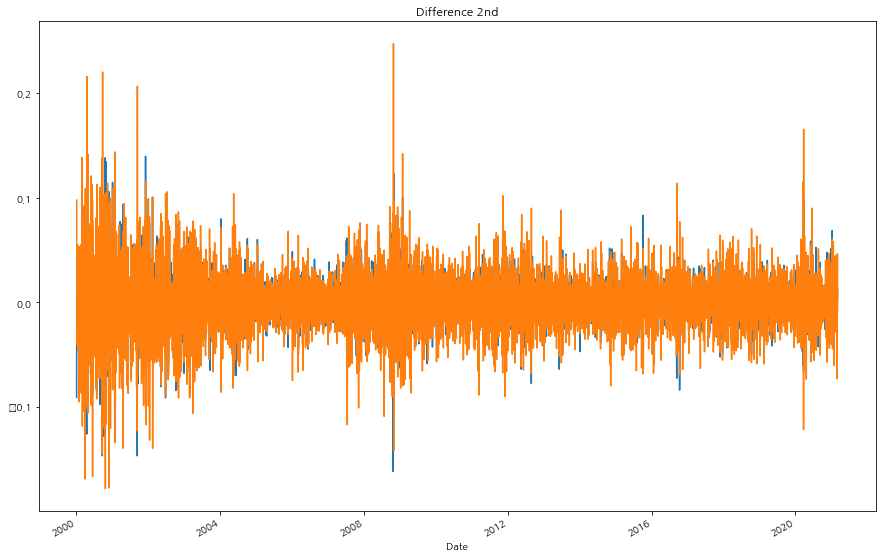

In [20]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

### Step 6. ARIMA 모델 훈련과 테스트

#### ARIMA 모델 빌드와 훈련
#### 모델 테스트 및 플로팅
#### 최종 예측 모델 정확도 측정(MAPE)

In [21]:
from statsmodels.tsa.arima_model import ARIMA

# Build Model
model = ARIMA(train_data, order=(2,1,0))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

/home/aiffel-dj12/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/aiffel-dj12/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 5292
Model:                 ARIMA(2, 1, 0)   Log Likelihood               12577.869
Method:                       css-mle   S.D. of innovations              0.022
Date:                Fri, 05 Mar 2021   AIC                         -25147.739
Time:                        02:10:40   BIC                         -25121.443
Sample:                             1   HQIC                        -25138.549
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0005      0.000      1.658      0.097   -9.14e-05       0.001
ar.L1.D.Close     0.0447      0.014      3.251      0.001       0.018       0.072
ar.L2.D.Close    -0.0642      0.014     

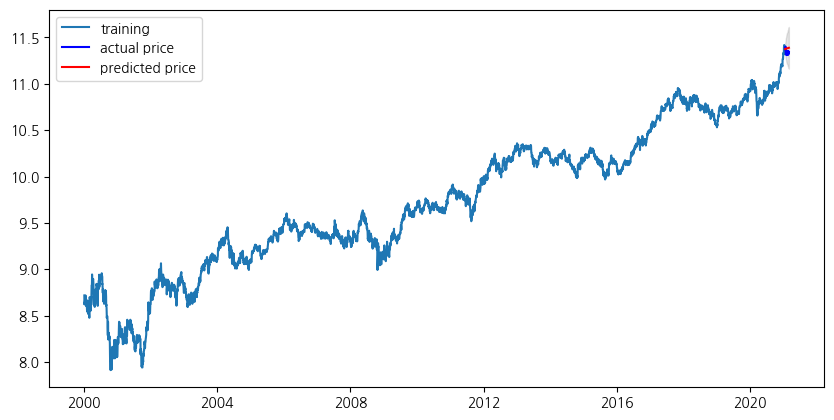

In [22]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [23]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  18782540.026374537
MAE:  3989.0478198201686
RMSE:  4333.88278872128
MAPE: 4.80%


### Step 7. 다른 주식 종목 예측

### HMM 예측

In [24]:
dataset_filepath = os.getenv('HOME')+'/aiffel/stock_prediction/data/HMM011200.KS.csv' 
df1 = pd.read_csv(dataset_filepath) 
print(type(df1))
df1 = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
df1.head()

<class 'pandas.core.frame.DataFrame'>


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-04,37378.613281,42906.437500,37378.613281,41011.183594,36448.367188,135433.0
2000-01-05,39537.097656,40537.367188,38536.824219,39273.867188,34904.343750,150723.0
2000-01-06,40274.140625,41274.410156,37010.089844,37168.027344,33032.796875,112202.0
2000-01-07,37220.675781,38273.593750,36852.152344,37694.488281,33500.683594,124966.0
2000-01-10,37905.070313,38957.992188,37483.906250,37905.070313,33687.832031,171010.0


### 대한항공 예측

In [25]:
dataset_filepath = os.getenv('HOME')+'/aiffel/stock_prediction/data/air003490.KS.csv' 
df2 = pd.read_csv(dataset_filepath) 
print(type(df2))
df2 = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
df2.head()

<class 'pandas.core.frame.DataFrame'>


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-04,10680.292969,11778.267578,10680.292969,11778.267578,11098.211914,2251546.0
2000-01-05,11578.635742,13075.873047,11079.556641,13075.873047,12320.895508,2649880.0
2000-01-06,12976.057617,12976.057617,11279.188477,11578.635742,10910.107422,1865535.0
2000-01-07,11977.899414,12227.438477,11379.003906,11977.899414,11286.316406,1596440.0
2000-01-10,11778.267578,12177.530273,11628.543945,11728.359375,11051.185547,1045826.0


In [26]:
ts2 = df1['Close'] #Close 로 시계열 데이터 변환 
ts3 = df2['Close'] #Close 로 시계열 데이터 변환 
print('HMM:',ts2.head(),'Air:',ts3.head())

HMM: Date
2000-01-04    41011.183594
2000-01-05    39273.867188
2000-01-06    37168.027344
2000-01-07    37694.488281
2000-01-10    37905.070313
Name: Close, dtype: float64 Air: Date
2000-01-04    11778.267578
2000-01-05    13075.873047
2000-01-06    11578.635742
2000-01-07    11977.899414
2000-01-10    11728.359375
Name: Close, dtype: float64


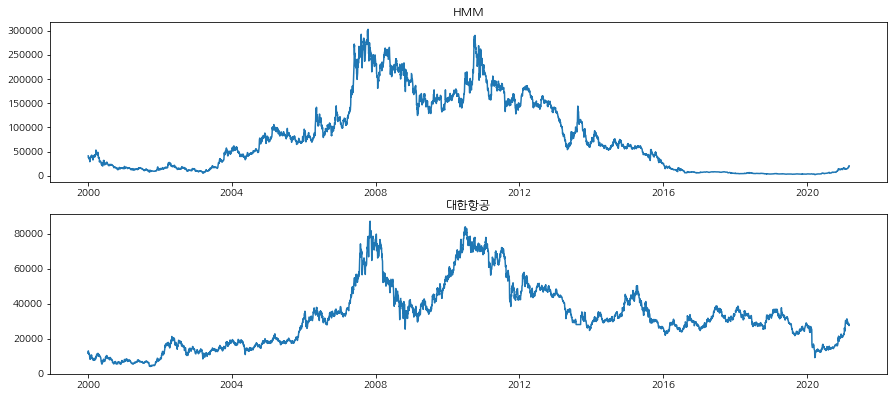

In [27]:
# 시계열(time series) 데이터를 차트로 그려 봅시다.
rcParams['figure.figsize'] = 15,10# 차트 크기
ax = plt.subplot(3,1,1)
plt.title('HMM')
plt.plot(ts2)

ax = plt.subplot(3,1,2)
plt.title('대한항공')
plt.plot(ts3)

### 전처리

In [28]:
print('HMM',ts2[ts2.isna()])
print('대한항공',ts3[ts3.isna()])


HMM Date
2005-01-03   NaN
2008-05-01   NaN
2008-05-05   NaN
2008-05-12   NaN
2008-06-06   NaN
2008-08-15   NaN
2008-09-15   NaN
2008-10-03   NaN
2008-12-25   NaN
2008-12-31   NaN
2017-11-16   NaN
2017-11-23   NaN
2018-01-02   NaN
2018-11-15   NaN
2019-11-14   NaN
Name: Close, dtype: float64
대한항공 Date
2005-01-03   NaN
2008-05-01   NaN
2008-05-05   NaN
2008-05-12   NaN
2008-06-06   NaN
2008-08-15   NaN
2008-09-15   NaN
2008-10-03   NaN
2008-12-25   NaN
2008-12-31   NaN
2017-11-16   NaN
2017-11-23   NaN
2018-01-02   NaN
2018-11-15   NaN
2019-11-14   NaN
Name: Close, dtype: float64


In [29]:
#HMM
ts2=ts2.interpolate(method='time')
ts2[ts2.isna()]
#대한항공
ts3=ts3.interpolate(method='time')
ts3[ts3.isna()]

Series([], Name: Close, dtype: float64)

### 로그변환

In [30]:
#HMM
ts_log1 = np.log(ts2)
#대한항공
ts_log2 = np.log(ts3)

### 시계열 안정성 분석

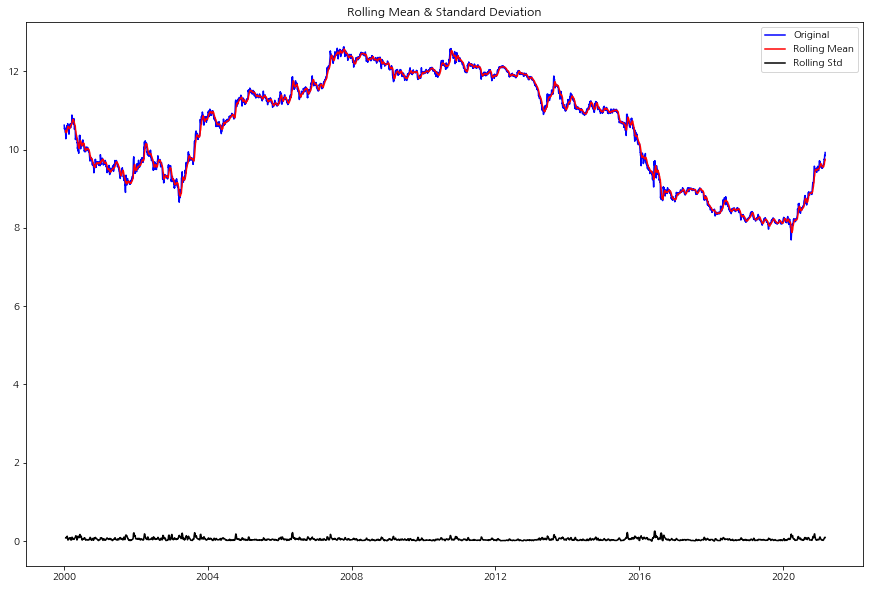

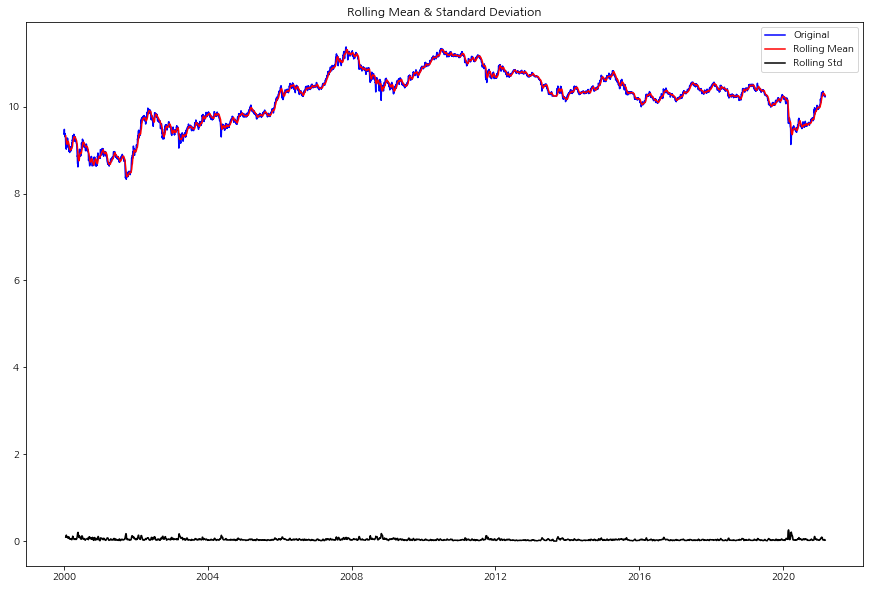

In [31]:
#HMM
plot_rolling_statistics(ts_log1, window=12),
#대한항공
plot_rolling_statistics(ts_log2, window=12)


#### 정량적 ADF Test

In [32]:
print('HMM')
augmented_dickey_fuller_test(ts_log1)
print('------------------------------------------------')
print('대한항공')
augmented_dickey_fuller_test(ts_log2)



HMM
Results of Dickey-Fuller Test:
Test Statistic                   -0.974408
p-value                           0.762484
#Lags Used                        6.000000
Number of Observations Used    5313.000000
Critical Value (1%)              -3.431581
Critical Value (5%)              -2.862084
Critical Value (10%)             -2.567060
dtype: float64
------------------------------------------------
대한항공
Results of Dickey-Fuller Test:
Test Statistic                   -1.991843
p-value                           0.290161
#Lags Used                       21.000000
Number of Observations Used    5298.000000
Critical Value (1%)              -3.431585
Critical Value (5%)              -2.862086
Critical Value (10%)             -2.567060
dtype: float64


#### 시계열 분해

/home/aiffel-dj12/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/aiffel-dj12/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


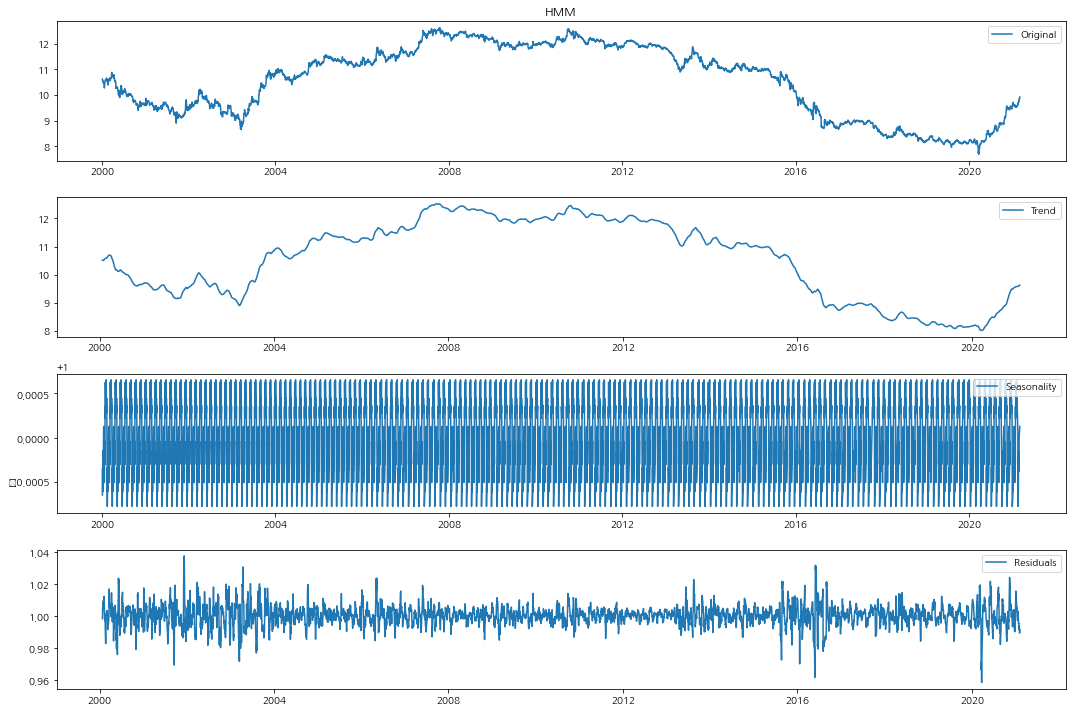

In [33]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition1 = seasonal_decompose(ts_log1, model='multiplicative', period = 30) 

trend1 = decomposition1.trend
seasonal1 = decomposition1.seasonal
residual1 = decomposition1.resid

plt.subplot(411)
plt.plot(ts_log1, label='Original')
plt.legend(loc='best')
plt.title('HMM')
plt.subplot(412)
plt.plot(trend1, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal1,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual1, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [34]:
residual1.dropna(inplace=True)
augmented_dickey_fuller_test(residual1)

Results of Dickey-Fuller Test:
Test Statistic                  -19.230739
p-value                           0.000000
#Lags Used                       30.000000
Number of Observations Used    5259.000000
Critical Value (1%)              -3.431594
Critical Value (5%)              -2.862090
Critical Value (10%)             -2.567063
dtype: float64


/home/aiffel-dj12/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/aiffel-dj12/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


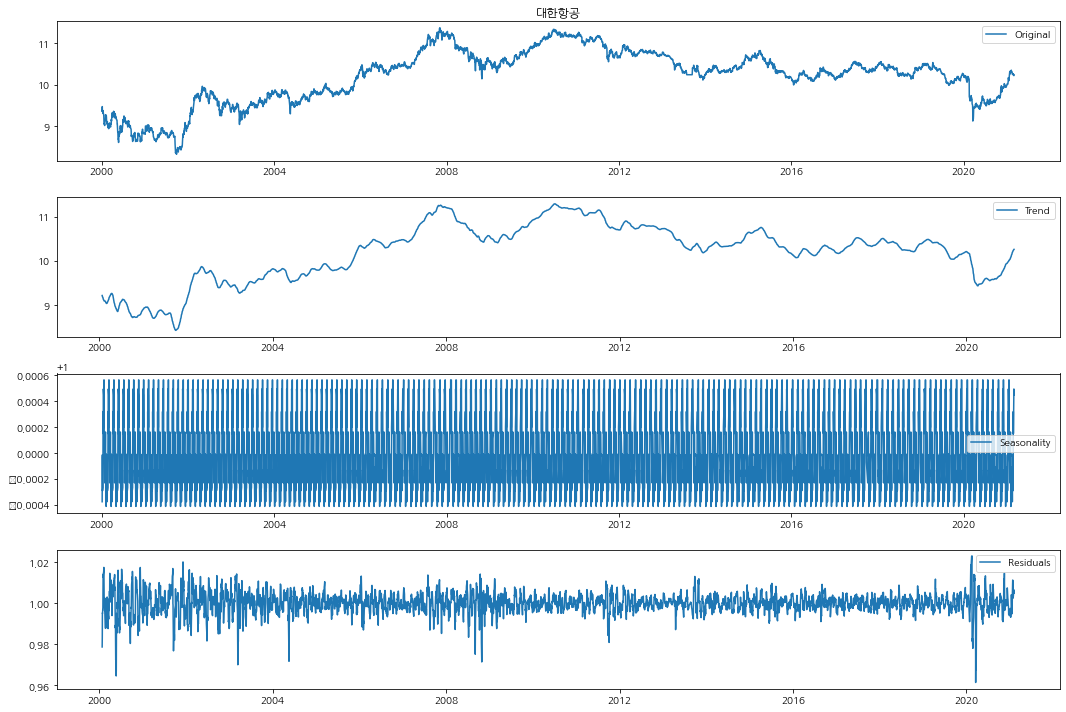

In [35]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition2 = seasonal_decompose(ts_log2, model='multiplicative', period = 30) 

trend2 = decomposition2.trend
seasonal2 = decomposition2.seasonal
residual2 = decomposition2.resid
plt.subplot(411)
plt.plot(ts_log2, label='Original')
plt.legend(loc='best')
plt.title('대한항공')
plt.subplot(412)
plt.plot(trend2, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal2,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual2, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [36]:
residual2.dropna(inplace=True)
augmented_dickey_fuller_test(residual2)

Results of Dickey-Fuller Test:
Test Statistic                  -20.287231
p-value                           0.000000
#Lags Used                       24.000000
Number of Observations Used    5265.000000
Critical Value (1%)              -3.431593
Critical Value (5%)              -2.862089
Critical Value (10%)             -2.567062
dtype: float64


### 학습 & 테스트 데이터셋 

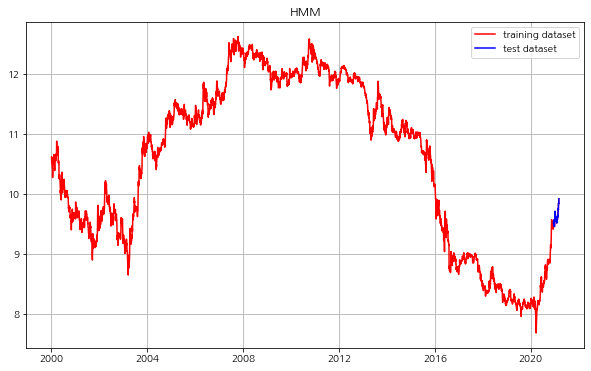

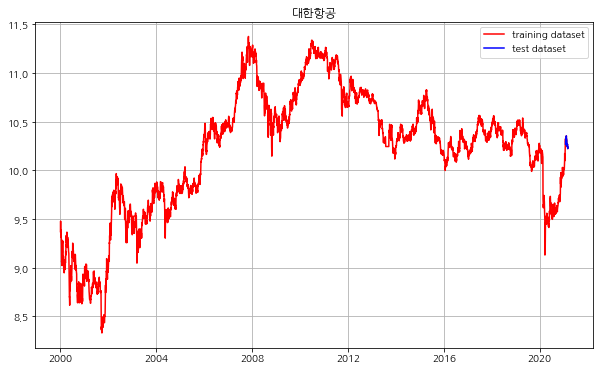

In [71]:
train_data1, test_data1 = ts_log1[:int(len(ts_log1)*0.99)], ts_log1[int(len(ts_log1)*0.99):]
plt.figure(figsize=(10,6))
plt.title('HMM')
plt.grid(True)
plt.plot(ts_log1, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data1, c='b', label='test dataset')
plt.legend()

train_data2, test_data2 = ts_log2[:int(len(ts_log2)*0.996)], ts_log2[int(len(ts_log2)*0.996):]
plt.figure(figsize=(10,6))
plt.title('대한항공')
plt.grid(True)
plt.plot(ts_log2, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data2, c='b', label='test dataset')
plt.legend()


### ACF, PACF 그려보기 -> p,q 구하기

/home/aiffel-dj12/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/aiffel-dj12/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


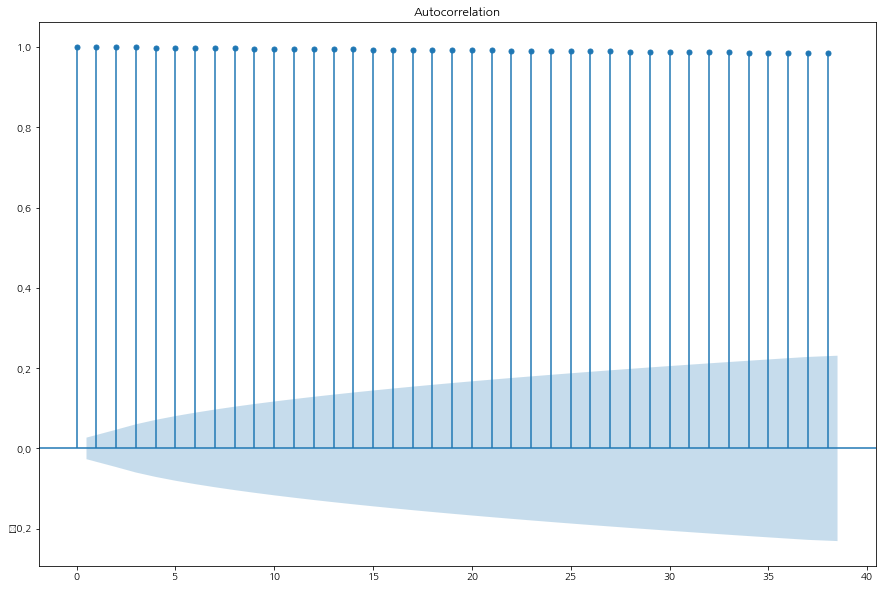

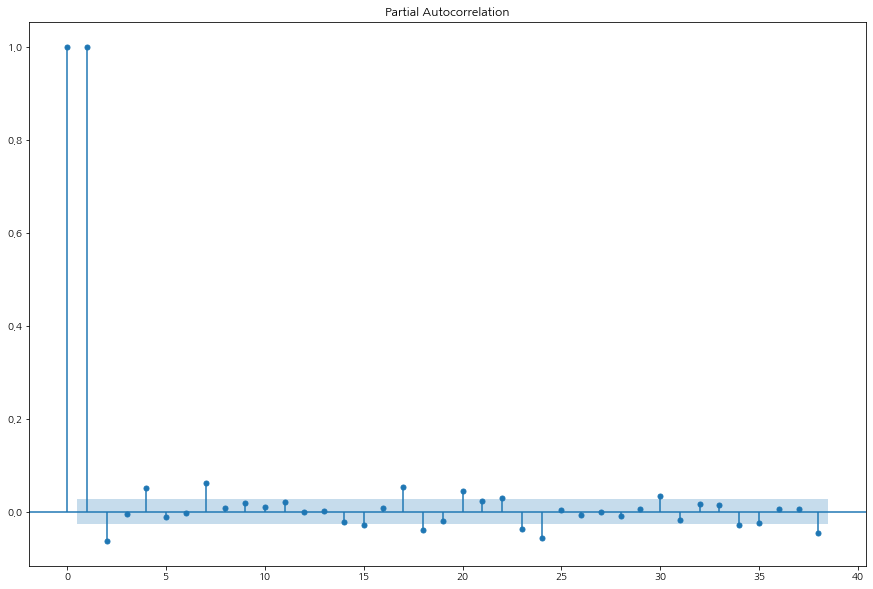

In [38]:
#HMM
plot_acf(ts_log1)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log1)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()


/home/aiffel-dj12/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/aiffel-dj12/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


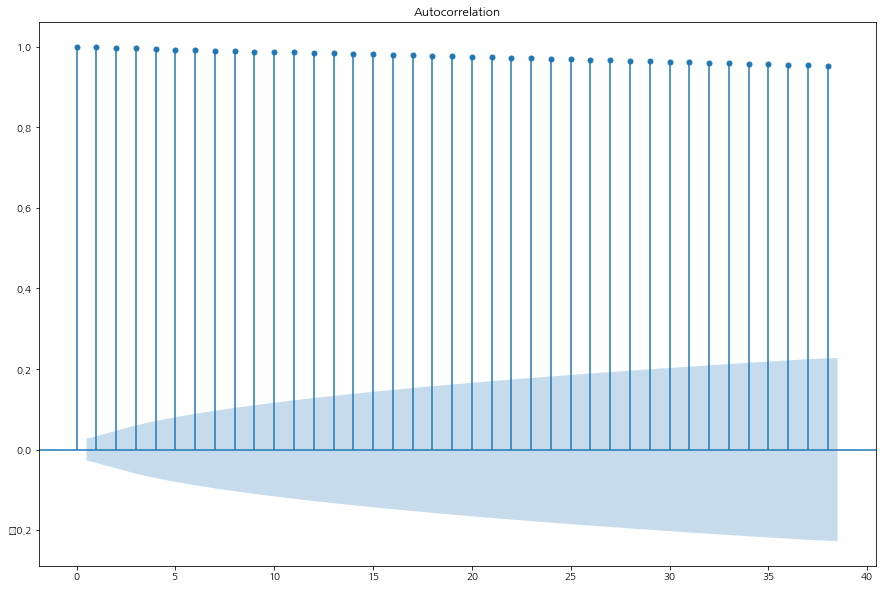

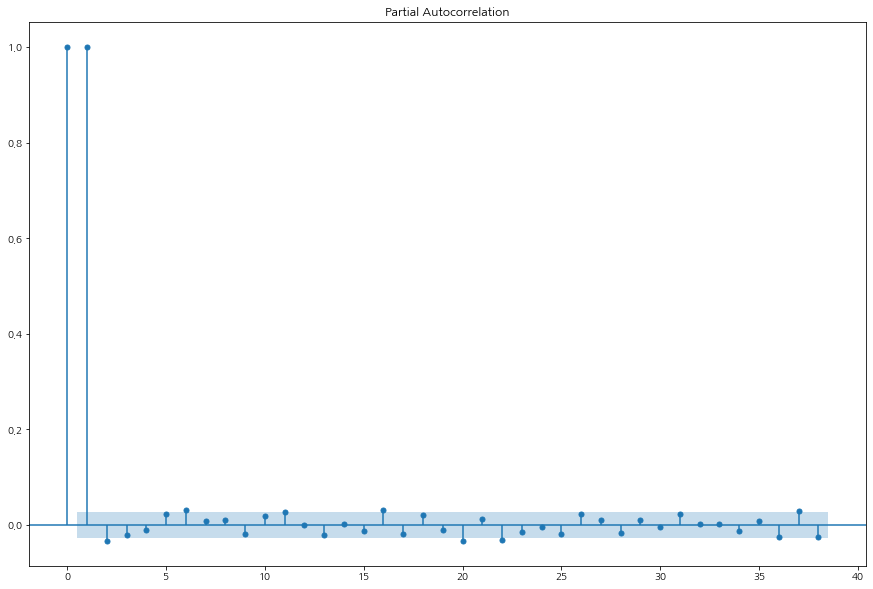

In [39]:
#대한항공
plot_acf(ts_log2)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log2)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                  -31.071434
p-value                           0.000000
#Lags Used                        5.000000
Number of Observations Used    5313.000000
Critical Value (1%)              -3.431581
Critical Value (5%)              -2.862084
Critical Value (10%)             -2.567060
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                  -22.078438
p-value                           0.000000
#Lags Used                       33.000000
Number of Observations Used    5284.000000
Critical Value (1%)              -3.431588
Critical Value (5%)              -2.862087
Critical Value (10%)             -2.567061
dtype: float64


/home/aiffel-dj12/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/aiffel-dj12/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


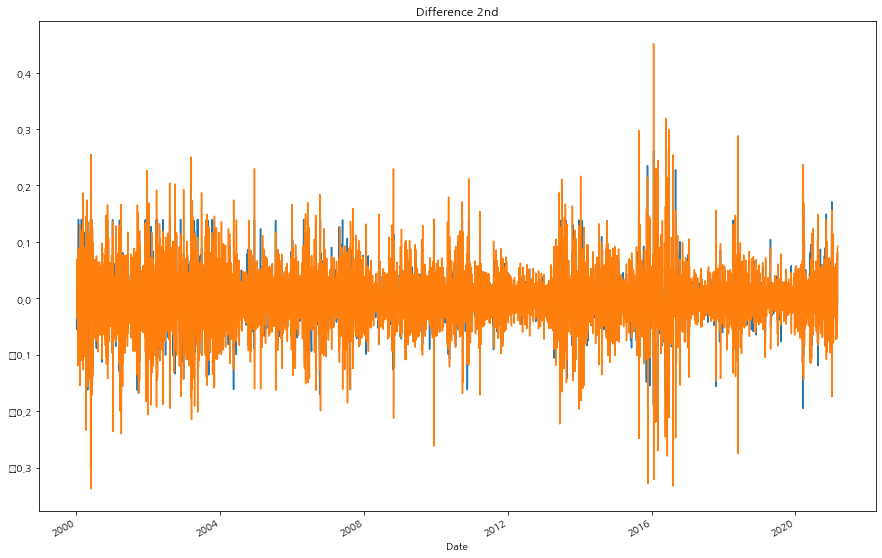

In [64]:
# 1차 차분 구하기, HMM
diff_1 = ts_log1.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

#2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)


### 차분 d구하기

Results of Dickey-Fuller Test:
Test Statistic                  -20.733870
p-value                           0.000000
#Lags Used                       14.000000
Number of Observations Used    5304.000000
Critical Value (1%)              -3.431583
Critical Value (5%)              -2.862085
Critical Value (10%)             -2.567060
dtype: float64


/home/aiffel-dj12/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/aiffel-dj12/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


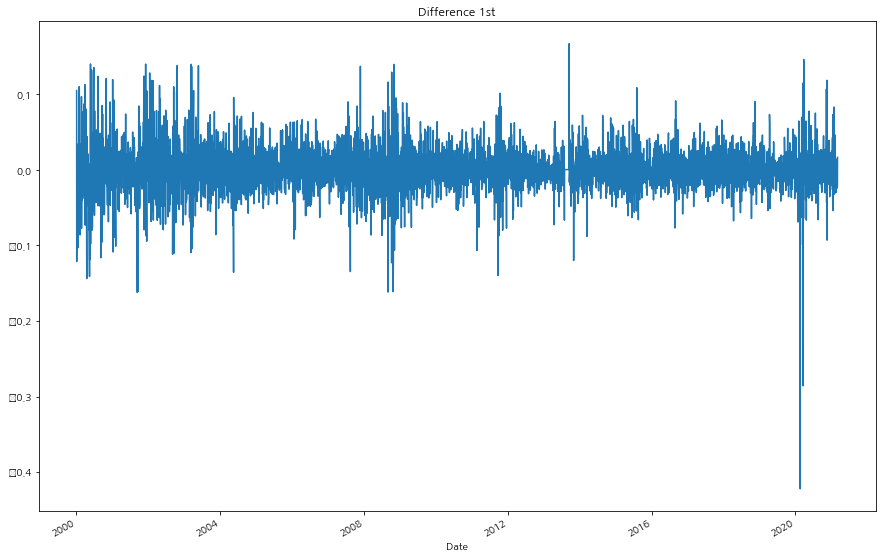

In [41]:
# 1차 차분 구하기 , 대한항공
diff_1 = ts_log2.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

### ARIMA 모델 훈련과 테스트

In [65]:
from statsmodels.tsa.arima_model import ARIMA

# Build Model
model = ARIMA(train_data1, order=(2, 2, 1))  
fitted_m = model.fit(disp=-1)  
print('HMM',fitted_m.summary())

/home/aiffel-dj12/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/aiffel-dj12/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has

HMM                              ARIMA Model Results                              
Dep. Variable:               D2.Close   No. Observations:                 5264
Model:                 ARIMA(2, 2, 1)   Log Likelihood                9513.935
Method:                       css-mle   S.D. of innovations              0.040
Date:                Fri, 05 Mar 2021   AIC                         -19017.871
Time:                        02:14:10   BIC                         -18985.027
Sample:                             2   HQIC                        -19006.390
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const           1.606e-06   3.28e-06      0.490      0.624   -4.82e-06    8.03e-06
ar.L1.D2.Close     0.0190      0.014      1.372      0.170      -0.008       0.046
ar.L2.D2.Close    -0.0062      0

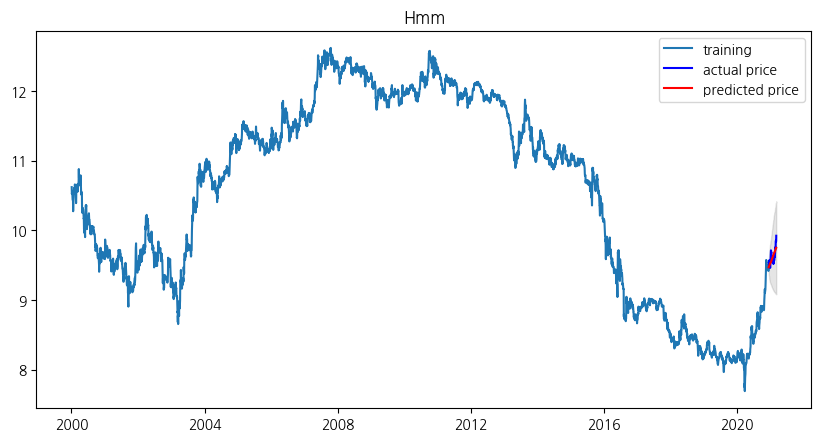

In [66]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data1), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data1.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data1.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data1.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.title('Hmm')
plt.plot(train_data1, label='training')
plt.plot(test_data1, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [67]:
mse = mean_squared_error(np.exp(test_data1), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data1), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data1), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data1))/np.abs(np.exp(test_data1)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  1540429.380672114
MAE:  996.1868153136106
RMSE:  1241.140354944643
MAPE: 6.54%


In [72]:
# Build Model 대한항공
model = ARIMA(train_data2, order=(1, 1, 0))  
fitted_m = model.fit(disp=-1)  
print('대한항공',fitted_m.summary())

대한항공                              ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 5297
Model:                 ARIMA(1, 1, 0)   Log Likelihood               11090.935
Method:                       css-mle   S.D. of innovations              0.030
Date:                Fri, 05 Mar 2021   AIC                         -22175.871
Time:                        02:15:44   BIC                         -22156.146
Sample:                             1   HQIC                        -22168.978
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0002      0.000      0.417      0.677      -0.001       0.001
ar.L1.D.Close     0.0507      0.014      3.692      0.000       0.024       0.078
                                   

/home/aiffel-dj12/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/aiffel-dj12/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has

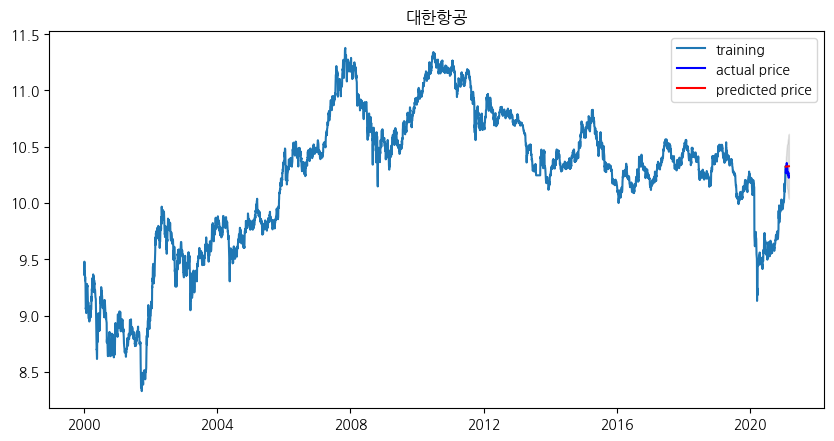

In [73]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data2), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data2.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data2.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data2.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.title('대한항공')
plt.plot(train_data2, label='training')
plt.plot(test_data2, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [74]:
mse = mean_squared_error(np.exp(test_data2), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data2), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data2), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data2))/np.abs(np.exp(test_data2)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  2520580.748260642
MAE:  1329.3772853256878
RMSE:  1587.6336946098877
MAPE: 4.64%


# 프로젝트를 마치며...

dropna 4.8